In [2]:
!pip install librosa
!pip install scikit-learn

In [3]:
!sudo apt-get install portaudio19-dev
!pip install --upgrade pip
!pip install pyaudio --no-binary pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (968 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

In [10]:
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 데이터 폴더 경로
data_folder = "/content/drive/MyDrive/NLP"  # 실제 데이터 폴더 경로로 변경

# 감정 라벨
emotions = ['angry', 'happy', 'neutral', 'sad']

# 데이터와 라벨을 저장할 리스트
data = []
labels = []

# 001~020 폴더 순회
for folder_num in range(1, 21):
    folder_name = f"{folder_num:03d}"  # 폴더 번호를 3자리 문자열로 변환 (예: 001, 002, ..., 020)
    folder_path = os.path.join(data_folder, folder_name)

    # sy, dy 폴더 순회
    for subfolder in ["st", "dy"]:
        subfolder_path = os.path.join(folder_path, subfolder)

        # 감정 폴더 순회
        for emotion in emotions:
            emotion_path = os.path.join(subfolder_path, emotion)

            # 오디오 파일 순회
            for filename in os.listdir(emotion_path):
                if filename.endswith(".wav"):
                    audio_path = os.path.join(emotion_path, filename)
                    y, sr = librosa.load(audio_path)

                    # MFCC 특징 추출
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                    mfccs = np.mean(mfccs.T, axis=0)

                    data.append(mfccs)
                    labels.append(emotion)

# 라벨 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# 데이터 분할
train_data, test_data, train_labels, test_labels = train_test_split(
    np.array(data), np.array(labels), test_size=0.2, random_state=42
)

# PyTorch Dataset 정의
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # CNN을 위한 차원 추가
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# DataLoader 생성
train_dataset = AudioDataset(train_data, train_labels)
test_dataset = AudioDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN 모델 정의
class AudioClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = torch.nn.Linear(64 * 3, num_classes)  # fully connected layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# 모델, 손실 함수, 옵티마이저 초기화
model = AudioClassifier(len(emotions))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 60
for epoch in range(num_epochs):
    for batch_data, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 모델 평가 (테스트 데이터셋)
correct = 0
total = 0
all_predicted = []  # 예측된 라벨을 저장할 리스트
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        outputs = model(batch_data)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        all_predicted.extend(predicted.numpy())  # 예측된 라벨을 리스트에 추가

print(f'Accuracy of the network on the test data: {100 * correct / total:.2f}%')

Epoch [1/60], Loss: 1.1512
Epoch [2/60], Loss: 1.2435
Epoch [3/60], Loss: 1.0929
Epoch [4/60], Loss: 1.0439
Epoch [5/60], Loss: 0.6490
Epoch [6/60], Loss: 0.8192
Epoch [7/60], Loss: 0.8315
Epoch [8/60], Loss: 0.7222
Epoch [9/60], Loss: 1.0239
Epoch [10/60], Loss: 0.7633
Epoch [11/60], Loss: 1.0087
Epoch [12/60], Loss: 0.5978
Epoch [13/60], Loss: 0.9129
Epoch [14/60], Loss: 1.3239
Epoch [15/60], Loss: 0.4824
Epoch [16/60], Loss: 0.7827
Epoch [17/60], Loss: 0.9455
Epoch [18/60], Loss: 0.5471
Epoch [19/60], Loss: 0.7915
Epoch [20/60], Loss: 0.7129
Epoch [21/60], Loss: 0.9301
Epoch [22/60], Loss: 0.9604
Epoch [23/60], Loss: 0.6702
Epoch [24/60], Loss: 0.7410
Epoch [25/60], Loss: 0.8590
Epoch [26/60], Loss: 1.2848
Epoch [27/60], Loss: 0.7441
Epoch [28/60], Loss: 0.7959
Epoch [29/60], Loss: 0.8080
Epoch [30/60], Loss: 0.7543
Epoch [31/60], Loss: 0.9995
Epoch [32/60], Loss: 0.5432
Epoch [33/60], Loss: 0.8391
Epoch [34/60], Loss: 0.7223
Epoch [35/60], Loss: 0.4066
Epoch [36/60], Loss: 0.5932
E

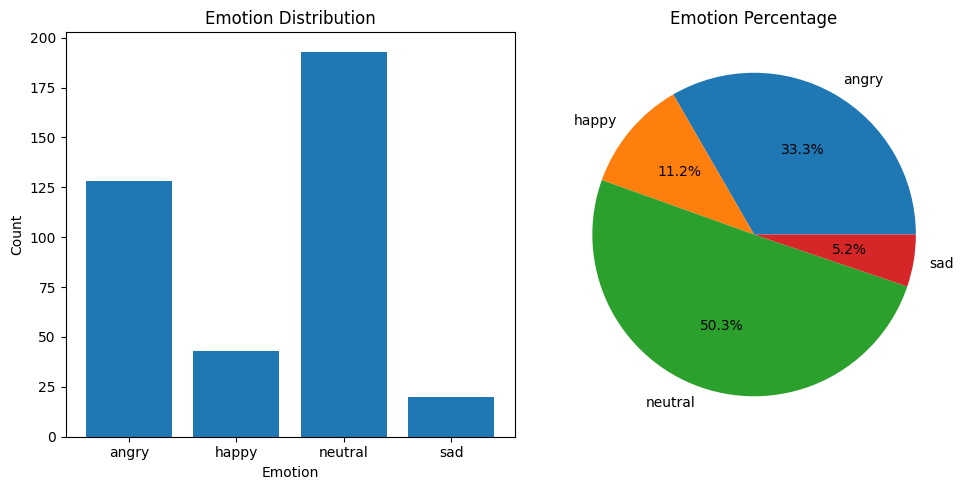

In [ ]:
# 감정 분포 시각화
emotion_counts = {emotion: all_predicted.count(label_encoder.transform([emotion])[0]) for emotion in emotions}
emotion_percentages = {emotion: count / len(all_predicted) * 100 for emotion, count in emotion_counts.items()}

plt.figure(figsize=(10, 5))

# 막대 그래프
plt.subplot(1, 2, 1)
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')

# 파이 차트
plt.subplot(1, 2, 2)
plt.pie(emotion_percentages.values(), labels=emotion_percentages.keys(), autopct='%1.1f%%')
plt.title('Emotion Percentage')

plt.tight_layout()
plt.show()

In [14]:
cd/content/NLP

/content/NLP


In [16]:
!git clone https://github.com/labatory/NLP.git

fatal: destination path 'NLP' already exists and is not an empty directory.
